In [531]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.transform import radon

## Utilize the GPU using CUDA

In [532]:
# CUDA for PyTorch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [533]:
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce GTX 1660 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    1.9 GB


## Step1_Data required for model training

In [534]:
# transform = transforms.Compose(transforms.ToTensor())
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

In [535]:
## MNIST Data
n_samples = 100
train_data = datasets.MNIST(root = './data', train = True, download = True).data / 255
test_data = datasets.MNIST(root = './data', train = False, download = True).data / 255
train_data.is_cuda, test_data.is_cuda

(False, False)

## Radon matrix construction 

In [536]:
# Radon Matrix exists for every angle and every line. matrix 
def getRadonMatrix(theta,ny,nx):
    colum_of_A = radon(np.zeros((ny,nx)), theta = theta) # this is only to know the size
    A = np.zeros((colum_of_A.size, nx*ny))
    for i in range(ny):
        for j in range(nx):
            basis_vec = np.zeros((ny,nx))
            basis_vec[i,j] = 1
            colum_of_A = radon(basis_vec, theta = theta)
            A[:,j+i*nx] = np.reshape(colum_of_A, colum_of_A.size)
    return torch.from_numpy(A).float()

In [537]:
nx, ny = train_data[1].shape 

# theta values for X ray incidence angles
theta = np.linspace(0,180,14,endpoint = True)

# call getRadonMatrix
A = getRadonMatrix(theta, ny, nx)

C:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


##  Noisy Sinogram vector using Radon matrix

In [538]:
def sinogram(image_data):
    sino_gram = image_data @ A.T
    noise_level = 0.01 
    sino_gram += noise_level * torch.randn(sino_gram.shape)
    return sino_gram.double()

In [539]:
train_data = np.reshape(train_data, (train_data.shape[0],train_data.shape[1]*train_data.shape[2]))
sinogram_train = sinogram(train_data)
test_data = np.reshape(test_data, (test_data.shape[0],test_data.shape[1]*test_data.shape[2]))
sinogram_test = sinogram(test_data)
train_data.is_cuda, sinogram_train.is_cuda 

(False, False)

In [540]:
sinogram_shape = sinogram_train.shape

## Dataloader to try batches of data

In [541]:
dataset_train = TensorDataset(sinogram_train.double(), train_data.double())

In [542]:
# train_loader = DataLoader(dataset = (sinogram_train, train_data), batch_size=20, shuffle=False)
train_loader = DataLoader(dataset = dataset_train, batch_size=20, shuffle=False)

## Step2_Network architecture

In [543]:
import torch
import torch.nn as nn
import torch.functional as F


class my_network(nn.Module):
    def __init__(self,dimension_of_sinogram , number_of_pixels):
        super().__init__()
        self.encoder = nn.Sequential(
        #nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = (3,3), stride = 1),       ## 20, 
           
        nn.Linear(dimension_of_sinogram , number_of_pixels, bias=False),
        nn.Sigmoid(),      
        nn.Linear(number_of_pixels, number_of_pixels, bias=False)
        )
        
    def forward(self, x):
        return self.encoder(x)

## Step3_Model ingredients

In [544]:
model = my_network(A.shape[0],  A.shape[1])
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3) # stochastic gradient descent - torch.optim.SGD
model = model.double()

## Step4_Model Training - forward, backward, weight updates

In [548]:
number_of_epochs = 10
for epoch in range(number_of_epochs+1):
    
    for sinogram_input, image_target in train_loader:

        # forward pass and loss
        prediction = model(sinogram_input)
        loss = criterion(prediction, image_target)

        # backward pass - gradients calculated here
        loss.backward()

        # update parameters
        optim.step()
        
        # If not use zero_grad() =>> the loss will increase not decrease as required.
        # So, to zero the gradients in before iteration =>>
        optim.zero_grad()
        
    if epoch%5 == 0:
        print(loss)

tensor(0.0085, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0073, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0092, dtype=torch.float64, grad_fn=<MseLossBackward0>)


## Step5_Plotting results

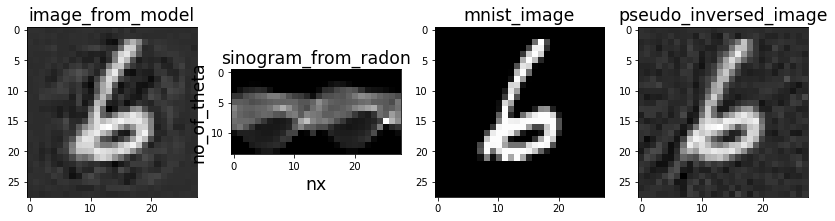

In [549]:
## all data to be in numpy arrays in cpu to plot using matplotlib.pyplot
sinogram_from_radon = sinogram_input.detach().numpy()
reconstruction = prediction.detach().numpy()
imageTarget = image_target.detach().numpy()
pseudo_inversed_image = sinogram_from_radon @ np.linalg.pinv(A.T)

f, axis = plt.subplots(nrows = 1,ncols = 4,sharex=True, figsize=(14,6), squeeze=True)

axis[0].imshow(np.reshape(reconstruction[1], (ny,nx)), cmap='gray')
axis[0].set_title('image_from_model', fontsize="xx-large")
axis[1].imshow(np.reshape(sinogram_from_radon[1], (14,nx)), cmap='gray')
axis[1].set_title('sinogram_from_radon', fontsize="xx-large")
axis[1].set_ylabel('no_of_theta', fontsize="xx-large")
axis[1].set_xlabel('nx', fontsize="xx-large")
axis[2].imshow(np.reshape(imageTarget[1], (ny,nx)), cmap='gray')
axis[2].set_title('mnist_image', fontsize="xx-large")
axis[3].imshow(np.reshape(pseudo_inversed_image[1], (ny,nx)), cmap='gray')
axis[3].set_title('pseudo_inversed_image', fontsize="xx-large")

plt.savefig('sinogram and image')
plt.show()

## Step6_Save the model

In [550]:
torch.save(model.state_dict(), './model_two_linear_with_Sigmoid_activation')